In [1]:
%matplotlib inline

In [2]:
from grale.all_nb import *

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [3]:
cosm = cosmology.Cosmology(0.7, 0.27, 0, 0.73)
cosmology.setDefaultCosmology(cosm)
D = cosm.getAngularDiameterDistance

In [4]:
zd = 0.5
zs1 = 1.2
zs2 = 1.8

In [5]:
nsie = lenses.NSIELens(D(zd), {"velocityDispersion": 1300000, "coreRadius": 1.5*ANGLE_ARCSEC, "ellipticity": 0.8})

pos1, sz1 = V(10,5)*ANGLE_ARCSEC, 1.1*ANGLE_ARCSEC
pos2, sz2 = V(2, -4.5)*ANGLE_ARCSEC, 0.8*ANGLE_ARCSEC

src1 = images.EllipticalSource(pos1, sz1, 0.6, 30)
src2 = images.EllipticalSource(pos2, sz2, 0.4, 110)

li = plotutil.LensInfo(nsie, size=80*ANGLE_ARCSEC, zd=zd)
liDetail = plotutil.LensInfo(nsie, size=80*ANGLE_ARCSEC, zd=zd, numxy=2047)

Text(value='')

FloatProgress(value=0.0)

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

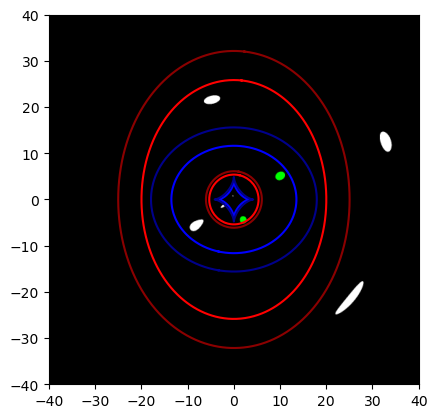

In [6]:
plotutil.plotImagePlane(li, sources=[{"shape": src1, "z": zs1},
                                       {"shape": src2, "z": zs2}], 
                        critColor=["red", "darkred"], caustColor=["blue", "darkblue"])

In [7]:
critDens1 = lenses.getCriticalDensity(D(zd), D(zs1), D(zd, zs1))
critDens2 = lenses.getCriticalDensity(D(zd), D(zs2), D(zd, zs2))
critDens1, critDens2

(5.425107152785962, 4.4133315380526295)

In [8]:
def getImageData(li, srcShape, zs):
    li.setSourceRedshift(zs)
    ip = li.getImagePlane()
    segs = ip.segment(ip.renderImages([srcShape]))
    
    imgData = images.ImagesData(len(segs))
    for idx, seg in enumerate(segs):
        for pt in seg:
            imgData.addPoint(idx, pt)
    return imgData

imgDat1 = getImageData(liDetail, src1, zs1)
imgDat2 = getImageData(liDetail, src2, zs2)

iws = inversion.InversionWorkSpace(zd, 80*ANGLE_ARCSEC)
iws.addImageDataToList(imgDat1, zs1, "extendedimages")
iws.addImageDataToList(imgDat2, zs2, "extendedimages")

Text(value='')

FloatProgress(value=0.0)

Text(value='')

In [13]:
def getMultiMSDLensAndSources(lambda1, lambda2, HW, N, potGradWeight, exactDeflectionTolerance, solver):

    sheet1 = lenses.MassSheetLens(D(zd), {"density": critDens1})
    sheet2 = lenses.MassSheetLens(D(zd), {"density": critDens2})

    msd1 = lenses.CompositeLens(D(zd),[
        { "lens": nsie, "factor": lambda1, "angle": 0, "x": 0, "y": 0 },
        { "lens": sheet1, "factor": (1.0-lambda1), "angle": 0, "x": 0, "y": 0 },
    ])
    msd2 = lenses.CompositeLens(D(zd),[
        { "lens": nsie, "factor": lambda2, "angle": 0, "x": 0, "y": 0 },
        { "lens": sheet2, "factor": (1.0-lambda2), "angle": 0, "x": 0, "y": 0 },
    ])
    
    tr = V(HW,HW)*ANGLE_ARCSEC
    bl = -tr
    _, img1Mask = util.createThetaGridAndImagesMask(bl, tr, N, N, [ imgDat1 ])
    _, img2Mask = util.createThetaGridAndImagesMask(bl, tr, N, N, [ imgDat2 ])
    
    #plt.imshow(img1Mask|img2Mask)
    
    dummyMask = np.zeros((N,N), dtype=bool)
    dummyMask[N//2,N//2] = True
    
    r = lenses.createEquivalentPotentialGridLens(nsie, bl, tr, N, N, [ dummyMask ],
                                             potGradWeight, 1, 0, pixelEnlargements=0,
                                             qpsolver=solver,
                                             exactDeflectionConstraints=[
                                                 { "maskRegions": [ img1Mask ], "lens": msd1 },
                                                 { "maskRegions": [ img2Mask ], "lens": msd2 },
                                             ],
                                             exactDeflectionTolerance=exactDeflectionTolerance,
                                             feedbackObject="stdout"
                                            )
    
    newLens = r["philens_equiv"]
    # Rescaling is towards (0,0), which makes the new position easy
    src1New = images.EllipticalSource(pos1*lambda1, sz1*lambda1, 0.6, 30)
    src2New = images.EllipticalSource(pos2*lambda2, sz2*lambda2, 0.4, 110)
    return newLens, src1New, src2New

In [29]:
lambdas=[None, [1,1], [0.75,1], [0.9, 0.8]]

In [30]:
newLens, src1New, src2New = getMultiMSDLensAndSources(*lambdas[1], 50, 256, 0.00002, 0.1*ANGLE_ARCSEC, "scs")

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 19.1 seconds


In [31]:
newLens2, src1New2, src2New2 = getMultiMSDLensAndSources(*lambdas[2], 50, 256, 0.00002, 0.1*ANGLE_ARCSEC, "scs")

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 18.8 seconds


In [32]:
newLens3, src1New3, src2New3 = getMultiMSDLensAndSources(*lambdas[3], 50, 256, 0.00002, 0.1*ANGLE_ARCSEC, "scs")

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 18.8 seconds


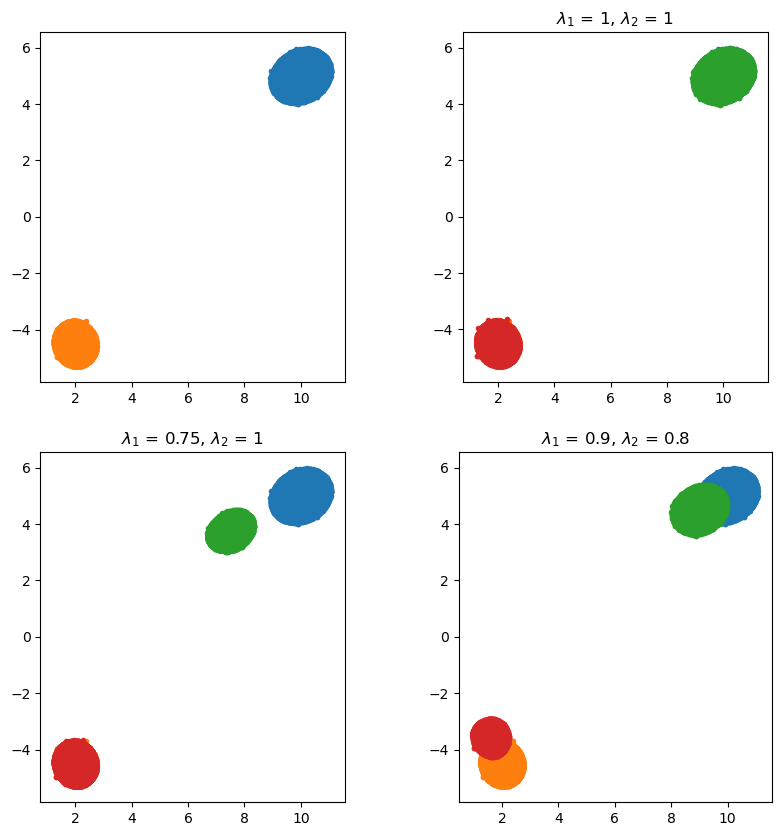

In [35]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plotutil.plotImagesData(iws.backProject(nsie))
plt.gca().set_aspect("equal")
plt.subplot(2,2,2)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[1]))
plotutil.plotImagesData(iws.backProject(nsie))
plotutil.plotImagesData(iws.backProject(newLens))
plt.gca().set_aspect("equal")
plt.subplot(2,2,3)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[2]))
plotutil.plotImagesData(iws.backProject(nsie))
plotutil.plotImagesData(iws.backProject(newLens2))
plt.gca().set_aspect("equal")
plt.subplot(2,2,4)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[3]))
plotutil.plotImagesData(iws.backProject(nsie))
plotutil.plotImagesData(iws.backProject(newLens3))
plt.gca().set_aspect("equal")

In [21]:
liNew = plotutil.LensInfo(newLens, size=80*ANGLE_ARCSEC,zd=zd)
liNew2 = plotutil.LensInfo(newLens2, size=80*ANGLE_ARCSEC,zd=zd)
liNew3 = plotutil.LensInfo(newLens3, size=80*ANGLE_ARCSEC,zd=zd)

In [22]:
plotutil.plotDensityInteractive(liNew, densityUnit=critDens1)

Text(value='')

FloatProgress(value=0.0)

In [23]:
plotutil.plotDensityInteractive(liNew2, densityUnit=critDens1)

Text(value='')

FloatProgress(value=0.0)

In [24]:
plotutil.plotDensityInteractive(liNew3, densityUnit=critDens1)

Text(value='')

FloatProgress(value=0.0)

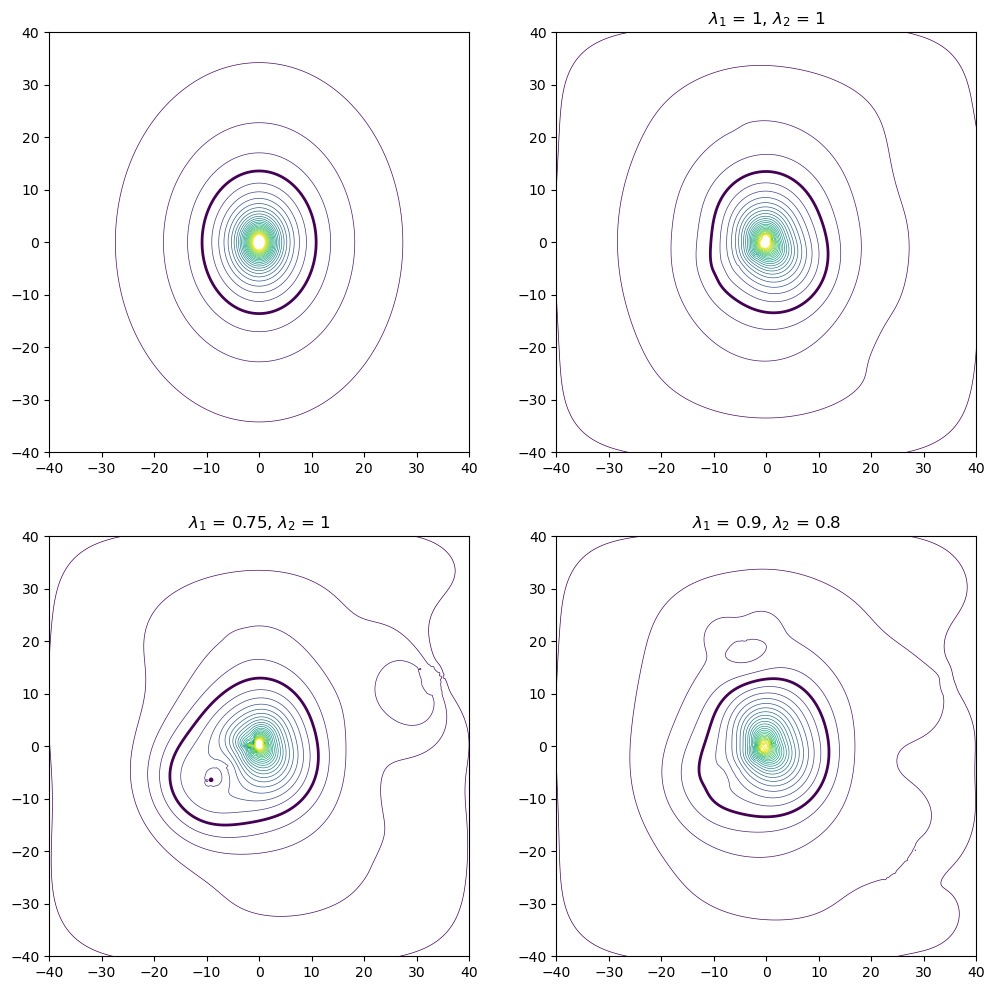

In [36]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plotutil.plotDensityContours(li, densityUnit=critDens1, levels=np.arange(0.2, 6, 0.2),linewidths=0.5)
plotutil.plotDensityContours(li, densityUnit=critDens1, levels=[1], linewidths=2)
plt.subplot(2,2,2)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[1]))
plotutil.plotDensityContours(liNew, densityUnit=critDens1, levels=np.arange(0.2, 6, 0.2),linewidths=0.5)
plotutil.plotDensityContours(liNew, densityUnit=critDens1, levels=[1], linewidths=2)
plt.subplot(2,2,3)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[2]))
plotutil.plotDensityContours(liNew2, densityUnit=critDens1, levels=np.arange(0.2, 6, 0.2),linewidths=0.5)
plotutil.plotDensityContours(liNew2, densityUnit=critDens1, levels=[1], linewidths=2)
plt.subplot(2,2,4)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[3]))
plotutil.plotDensityContours(liNew3, densityUnit=critDens1, levels=np.arange(0.2, 6, 0.2),linewidths=0.5)
plotutil.plotDensityContours(liNew3, densityUnit=critDens1, levels=[1], linewidths=2)

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

Text(value='')

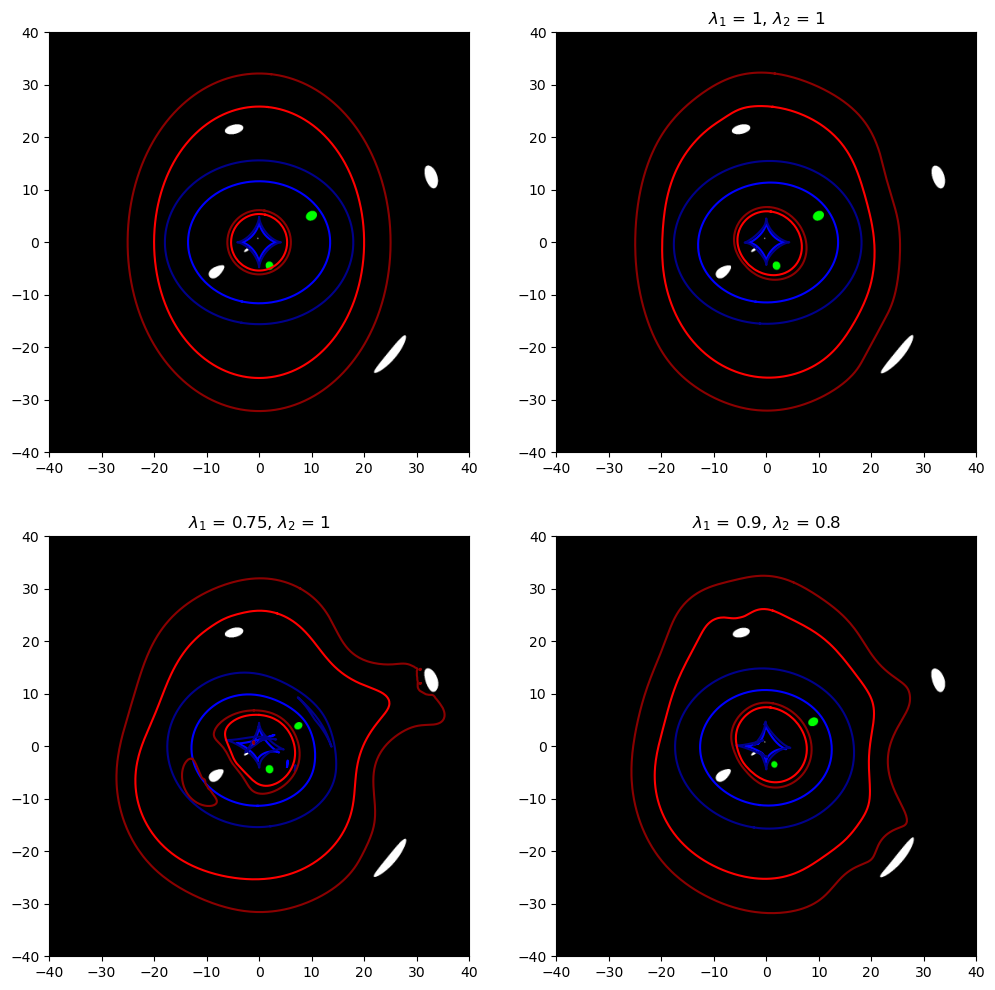

In [37]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plotutil.plotImagePlane(li, sources=[{"shape": src1, "z": zs1},
                                       {"shape": src2, "z": zs2}], 
                        critColor=["red", "darkred"], caustColor=["blue", "darkblue"])
plt.subplot(2,2,2)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[1]))
plotutil.plotImagePlane(liNew, sources=[{"shape": src1New, "z": zs1},
                                        {"shape": src2New, "z": zs2}],
                        critColor=["red", "darkred"], caustColor=["blue", "darkblue"])
plt.subplot(2,2,3)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[2]))
plotutil.plotImagePlane(liNew2, sources=[{"shape": src1New2, "z": zs1},
                                         {"shape": src2New2, "z": zs2}],
                        critColor=["red", "darkred"], caustColor=["blue", "darkblue"])
plt.subplot(2,2,4)
plt.title("$\lambda_1$ = {}, $\lambda_2$ = {}".format(*lambdas[3]))
plotutil.plotImagePlane(liNew3, sources=[{"shape": src1New3, "z": zs1},
                                         {"shape": src2New3, "z": zs2}],
                        critColor=["red", "darkred"], caustColor=["blue", "darkblue"])